In [2]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import KFold
from tensorflow.keras.backend import clear_session
from proglearn.transformers import NeuralClassificationTransformer
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.voters import MLKNNClassificationVoter
from tensorflow.keras.optimizers import Adam
from proglearn.deciders import SimpleArgmaxAverage
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
seed = 1
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [4]:
image_size = 128
path = "./"
train_path = "./ISIC2018_Task1-2_Training_Input"

## Training Ids
train_ids = []
for files in os.walk(train_path):
   for name in files:
      train_ids.append(name)

train_ids = train_ids[2]
ids = [i.split('.', 1)[0] for i in train_ids]

def get_images(data_path, ids, image_size):
    images = np.zeros((len(ids), image_size, image_size, 3))
    masks = np.zeros((len(ids), image_size, image_size, 1))

    for i, id_name in enumerate(ids):
        image_path = os.path.join(data_path, "ISIC2018_Task1-2_Training_Input", id_name) + ".jpg"
        mask_path = os.path.join(data_path, "ISIC2018_Task1_Training_GroundTruth", id_name) + "_segmentation.png"
        image = cv2.imread(image_path,1)
        image = cv2.resize(image, (image_size, image_size))
        mask = np.zeros((image_size, image_size, 1))
        _mask = cv2.imread(mask_path, -1)
        _mask = cv2.resize(_mask, (image_size, image_size))
        _mask = np.expand_dims(_mask, axis=-1)
        mask = np.maximum(mask, _mask)
        
        
        ## Normalizaing 
        images[i,:,:,:] = image/255.0
        masks[i,:,:,:] = np.rint(mask/255.0)
    return images, masks

In [5]:
x, y = get_images(path, ids[:20], image_size)

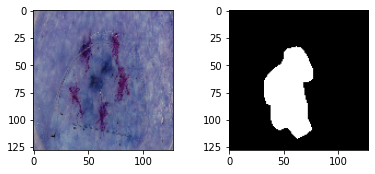

In [6]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(np.rint(y[r]), (image_size, image_size)), cmap="gray")

In [7]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [8]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) 
    c2, p2 = down_block(p1, f[1]) 
    c3, p3 = down_block(p2, f[2])
    c4, p4 = down_block(p3, f[3]) 
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [9]:
def dice(seg, gt):
    intersection = tf.reduce_sum(tf.cast(tf.equal(seg, gt), tf.float32))
    return intersection * 2.0 / tf.cast(tf.size(seg) + tf.size(gt), tf.float32)


In [10]:
# hyperparameters

num_tasks = 10
batch_size = 50
network_batch_size = 10
test_batch_size = batch_size // num_tasks

In [11]:
accuracies = np.full((num_tasks + 1, num_tasks, num_tasks), np.nan)

random.shuffle(ids)

data_ids = ids[:(num_tasks+1) * batch_size]
kf = KFold(n_splits=num_tasks+1)
for i, (train_index, test_index) in enumerate(kf.split(data_ids)):
    train_ids = [data_ids[i] for i in train_index]
    test_ids = [data_ids[i] for i in test_index]

    for task in range(0, num_tasks):
        print(f"Experiment {i}; Task {task}")
        clear_session()

        network = UNet()
        transformer = NeuralClassificationTransformer

        kwargs = {
                "network": network,
                "euclidean_layer_idx": -1,
                "loss": "categorical_crossentropy",
                "optimizer": Adam(1e-3),
                "fit_kwargs": {
                    "epochs": 100,
                    "callbacks": [EarlyStopping(patience=5, monitor="val_loss")],
                    "verbose": False,
                    "validation_split": 0.33,
                    "batch_size": network_batch_size,
                },
            }
        voter = MLKNNClassificationVoter
        voter_kwargs = {'k' : 2}
        learner = ProgressiveLearner(
                default_transformer_class=transformer,
                default_transformer_kwargs=kwargs,
                default_voter_class=voter,
                default_voter_kwargs = voter_kwargs
            )


        X_train, Y_train = get_images(path, train_ids[task * batch_size:(task + 1)*batch_size], image_size)
        learner.add_task(
                    X=X_train,
                    y=Y_train,
                    task_id=task,
                    num_transformers=1,
                    transformer_voter_decider_split=[0.67, 0.33, 0],
                    decider_kwargs={
                        "classes": np.unique(Y_train)
                    },
                )
        
        for t in range(task):
            X_test, Y_test = get_images(path, test_ids[t*test_batch_size:(t+1)*test_batch_size])
            prediction = learner.predict(
                X_test,
                task_id=t
            )
            accuracies[i][task][t] = np.mean(Y_test == prediction)

            X_train, Y_train = get_images(path, train_ids[t * batch_size:(t + 1)*batch_size], image_size)

            learner.add_task(
                    X=X_train,
                    y=Y_train,
                    task_id=t,
                    num_transformers=1,
                    transformer_voter_decider_split=[0.67, 0.33, 0],
                    decider_kwargs={
                        "classes": np.unique(Y_train)
                    },
                )
        
        X_test, Y_test = get_images(path, test_ids[task*test_batch_size:(task+1)*test_batch_size])
        prediction = learner.predict(
            X_test,
            task_id=task
        )

        accuracies[i][task][task] = np.mean(Y_test == prediction)

        for t in range(task+1, num_tasks):
            X_test, Y_test = get_images(path, test_ids[t*test_batch_size:(t+1)*test_batch_size])
            prediction = learner.predict(
                X_test,
                task_id=t
            )
            accuracies[i][task][t] = np.mean(Y_test == prediction)

            X_train, Y_train = get_images(path, train_ids[t * batch_size:(t + 1)*batch_size], image_size)

            learner.add_task(
                    X=X_train,
                    y=Y_train,
                    task_id=t,
                    num_transformers=1,
                    transformer_voter_decider_split=[0.67, 0.33, 0],
                    decider_kwargs={
                        "classes": np.unique(Y_train)
                    },
                )

Experiment 0; Task 0


2022-04-13 18:02:23.055696: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-13 18:02:23.080402: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3295010000 Hz
2022-04-13 18:02:23.080956: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ff8bd79100 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-13 18:02:23.080976: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


[[[[0.05490196 0.05882353 0.0745098 ]
   [0.05882353 0.05098039 0.05882353]
   [0.0745098  0.0627451  0.08235294]
   ...
   [0.56470588 0.50588235 0.45098039]
   [0.58431373 0.5372549  0.47843137]
   [0.61176471 0.54901961 0.51372549]]

  [[0.0627451  0.0627451  0.07843137]
   [0.05882353 0.05098039 0.05098039]
   [0.22745098 0.24705882 0.31764706]
   ...
   [0.57647059 0.51764706 0.45098039]
   [0.54117647 0.49411765 0.42745098]
   [0.55686275 0.49411765 0.44705882]]

  [[0.05882353 0.05882353 0.05882353]
   [0.06666667 0.0627451  0.07843137]
   [0.38823529 0.43529412 0.5254902 ]
   ...
   [0.48235294 0.40784314 0.34901961]
   [0.50980392 0.43921569 0.39607843]
   [0.60784314 0.55294118 0.47843137]]

  ...

  [[0.53333333 0.52941176 0.52941176]
   [0.51764706 0.50196078 0.49803922]
   [0.4627451  0.4627451  0.48627451]
   ...
   [0.10980392 0.10980392 0.1254902 ]
   [0.08235294 0.09411765 0.10196078]
   [0.09411765 0.08235294 0.10588235]]

  [[0.56862745 0.56078431 0.53333333]
   [0.5

ValueError: shape too large to be a matrix.

In [ ]:
accuracies = np.mean(accuracies, axis=0)

fte = [(1 - accuracies[t][0])/(1 - accuracies[t][t]) for t in range(num_tasks)]
bte = [[(1 - accuracies[t][t])/(1 - accuracies[t][k]) for k in range(t, num_tasks)] for t in range(num_tasks)]
te = [[fte[t] / bte[t][k] for k in range(len(bte[t]))] for t in range(num_tasks)]

NameError: name 'accuracies' is not defined

In [ ]:
plt.figure()
ax, fig = plt.subplots(2, 2, figsize=(16, 11.5))

# fte
ax[0][0].plot(np.arange(1, num_tasks + 1), fte)
ax[0][0].set_xlabel("Number of tasks seen")
ax[0][0].set_ylabel("FTE")

# bte
for t in range(num_tasks):
    ax[0][1].plot(np.arange(t+1, num_tasks+1), np.array(bte[t]))
ax[0][1].set_xlabel("Number of tasks seen")
ax[0][1].set_ylabel("BTE")

# te
for t in range(num_tasks):
    ax[0][1].plot(np.arange(t+1, num_tasks+1), np.array(te[t]))
ax[1][0].set_xlabel("Number of tasks seen")
ax[1][0].set_ylabel("TE")

# accuracy
for t in range(num_tasks):
    ax[0][1].plot(np.arange(t+1, num_tasks+1), np.array(accuracies[t][t:]))
ax[1][0].set_xlabel("Number of tasks seen")
ax[1][0].set_ylabel("Accuracy")